<a href="https://colab.research.google.com/github/Micah-Sanders/DATS6202/blob/main/DATS6202ProjectFINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATS 6202 Final Paper
## Aravind Meyyappan, Micah Sanders, and Remya Raju Sulabha
## June 27th, 2024

The Oxford English Dictionary defines a task is a piece of work to be done or
undertaken. We define a skill as the operationalized knowledge to complete a task. However, skills are not uniquely linked to tasks in that multiple skills may relate to a single task, or a single task may be completed by individuals with different skills. Further, individual skills may be sufficient to complete individual tasks in ways previously unknown. In short, the relationship between skills and tasks is complex and non-static.

Traditionally, skills are represented by hierarchical taxonomies, essentially a list of differentiated skills grouped by a series of general descriptors. There are an untold
number of skills taxonomies in existence ranging from a few skill definitions to
thousands of differentiated skills. However, these taxonomies tend not to overlap well; meaning that which taxonomy you are using to define a skill will impact what the skill is defined as. This is not optimal given the plethora of different task associations possible for skills.

Our goal is to broaden the skill definitions which represent skill clusters by
combining similar skill definitions across taxonomies. Put another way, we want to identify the cluster labels from taxonomy for skill definitions from another taxonomy. We will achieve this by using a recurrent neural network trained on data from Lightcast’s Open Skill Library (OSL). We will then use text analysis to apply cluster labels from Lightcast to another taxonomy, the European Commission’s ESCO Classification of skill and competencies.

## Load and Clean Lightcast Data

We have stored two files on a public github repository that each represent a flat version of Lightcast's OSL and ESCO's Taxonomy respectively. These are not complete repositories, but rather a list of included skills with category and sub-category information for both. We also do some basic pre-processing to drop NAs and remove stopwords. Stopwords are "verbal fluff" added to human language text that can confound models. The keywords rarely rely on stopwords to convey information and thus removing them serves to reduce processing time without significantly impacting meaning. We also split the data to remove an artefact of the Lightcast method of building skills lists which produces a large number of skills with a "NULL" category description. This reduces our trainable data (3554/8441 rows are coded as NULL) but helps remove noise from the data.

After cleaning, we also make sure to encode labels for the model. While the raw data uses numeric values, it's good practice to ensure the labels are correctly formatted.


In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Bidirectional, Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from gensim.parsing.preprocessing import remove_stopwords

# Load and preprocess Lightcast data
url = 'https://github.com/Micah-Sanders/DATS6202/raw/main/Lightcast.csv' #Set URL
lightcast_data = pd.read_csv(url) #Read in file from URL
lightcast_data = lightcast_data[['DESCRIPTION', 'CATEGORY']].dropna() #Drop missing data
lightcast_data = lightcast_data.drop(lightcast_data[lightcast_data.CATEGORY == 0].index) #Drop invalid category
lightcast_data['DESCRIPTION'] = lightcast_data['DESCRIPTION'].astype(str).apply(remove_stopwords) #Remove stop words

# Label encoding for categories and subcategories
category_encoder = LabelEncoder()
lightcast_data['CATEGORY_encoded'] = category_encoder.fit_transform(lightcast_data['CATEGORY'])
num_categories = lightcast_data['CATEGORY_encoded'].nunique()

## Preparing for Modeling
We next split the data into test/train dataset. We've chosen a 70/30 as a typical split distribution. This is followed by text vetorization which converts skill strings to computer readable values. In this process we also standardize the words (strip punctuation and uppercase letters) and assume whitespace delineates words to vectorize. We also generate the numpy array for the model.

In [ ]:
# Splitting the dataset into train and test sets
train_data, test_data = train_test_split(lightcast_data, test_size=0.30, random_state=42)

# Text vectorization
vectorizer = TextVectorization(max_tokens=10000,
                               standardize="lower_and_strip_punctuation",
                               split="whitespace",
                               ngrams=None,
                               output_mode="int",
                               output_sequence_length=100)
text_ds = tf.data.Dataset.from_tensor_slices(train_data['DESCRIPTION']).batch(128)
vectorizer.adapt(text_ds)

# Training datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_data['DESCRIPTION'], train_data['CATEGORY_encoded'])).batch(64)
val_ds = tf.data.Dataset.from_tensor_slices((test_data['DESCRIPTION'], test_data['CATEGORY_encoded'])).batch(64)

## Model Definition
As this task is a text classification problem, we chose to implement a long short-term memory (LSTM) version of a recurrent neural network (RNN). This model was chosen over a convolutional neural network (CNN) as natural language sequences (such as sentences) are sequential in nature. While CNNs are quite efficient at identifying local patterns, the relationship between words is better represented by RNNs.

We selected a sequential model with a bidirectional LSTM layer to overcome the typical variance in word order within sentence structures. We also add an RELU layer to force training values toward extremes and thus reduce weaker relationships in the softmax layer. Testing without the RELU layer showed lower accuracy suggesting this layer was beneficial.


In [ ]:
# Model definition
model = Sequential([
    vectorizer,
    Embedding(10000, 128, mask_zero=True),
    Bidirectional(LSTM(128)),
    Dense(128, activation='relu'),
    Dense(num_categories, activation='softmax', name='category_output')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 100)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 100, 128)          1280000   
                                                                 
 bidirectional (Bidirection  (None, 256)               263168    
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 category_output (Dense)     (None, 29)                3741      
                                                                 
Total params: 1579805 (6.03 MB)
Trainable params: 157980

## Train Model
We now need to actually train a model. To do so, we use the training and validation data as vectorized strings. We chose 10 epochs after testing 15 epochs and finding that the var_loss accelerated at the 11th epoch indicating overfitting.

Epoch 1/10
54/54 [==============================] - 54s 790ms/step - loss: 1.8629 - accuracy: 0.6224 - val_loss: 1.4727 - val_accuracy: 0.6164
Epoch 2/10
54/54 [==============================] - 35s 642ms/step - loss: 1.2186 - accuracy: 0.6563 - val_loss: 1.3783 - val_accuracy: 0.6307
Epoch 3/10
54/54 [==============================] - 36s 657ms/step - loss: 0.9526 - accuracy: 0.7040 - val_loss: 1.4987 - val_accuracy: 0.6416
Epoch 4/10
54/54 [==============================] - 37s 693ms/step - loss: 0.7102 - accuracy: 0.7769 - val_loss: 1.2850 - val_accuracy: 0.6846
Epoch 5/10
54/54 [==============================] - 38s 712ms/step - loss: 0.4789 - accuracy: 0.8589 - val_loss: 1.4200 - val_accuracy: 0.7174
Epoch 6/10
54/54 [==============================] - 37s 673ms/step - loss: 0.3569 - accuracy: 0.8967 - val_loss: 1.5264 - val_accuracy: 0.7167
Epoch 7/10
54/54 [==============================] - 39s 730ms/step - loss: 0.2730 - accuracy: 0.9204 - val_loss: 1.2837 - val_accuracy: 0.7208

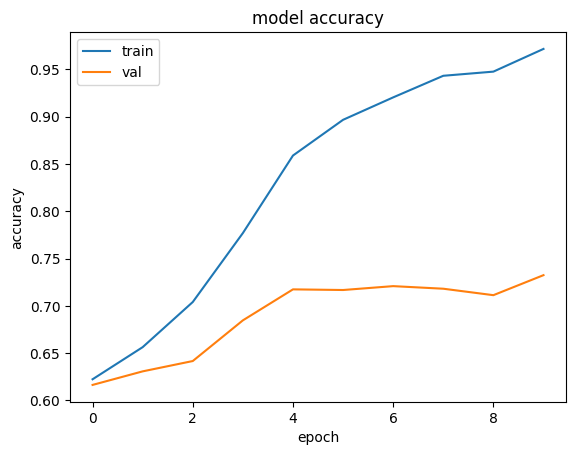

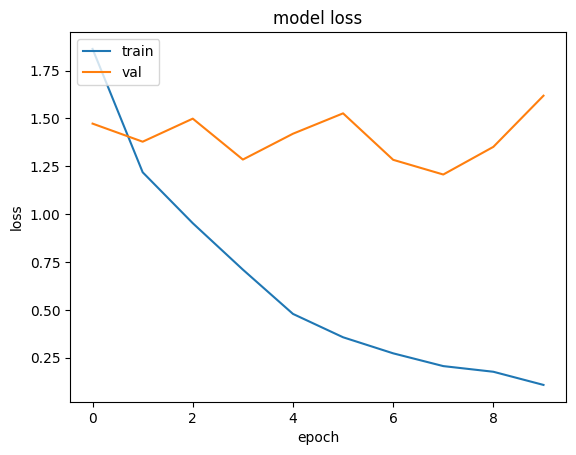

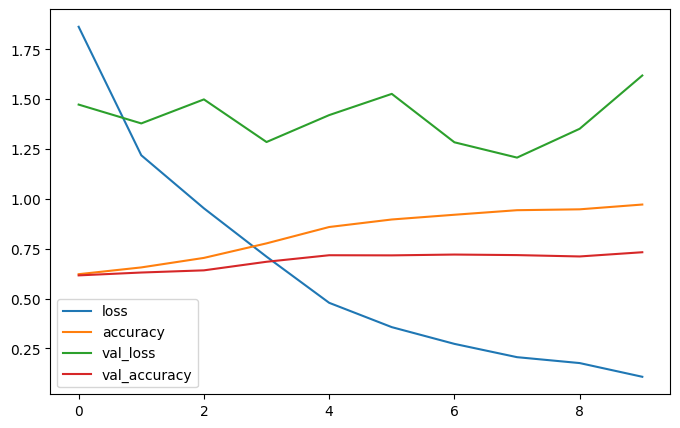

In [ ]:
# Model training
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

#Plot Accuracy vs. val_accuracy
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot Loss vs. val_loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Plot All
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

## Evaluate Model
With the model trained, we now take a look at the evaluative metrics for the training.

23/23 [==============================] - 7s 277ms/step - loss: 1.6185 - accuracy: 0.7324
Test Accuracy: 73.24%
23/23 [==============================] - 15s 299ms/step


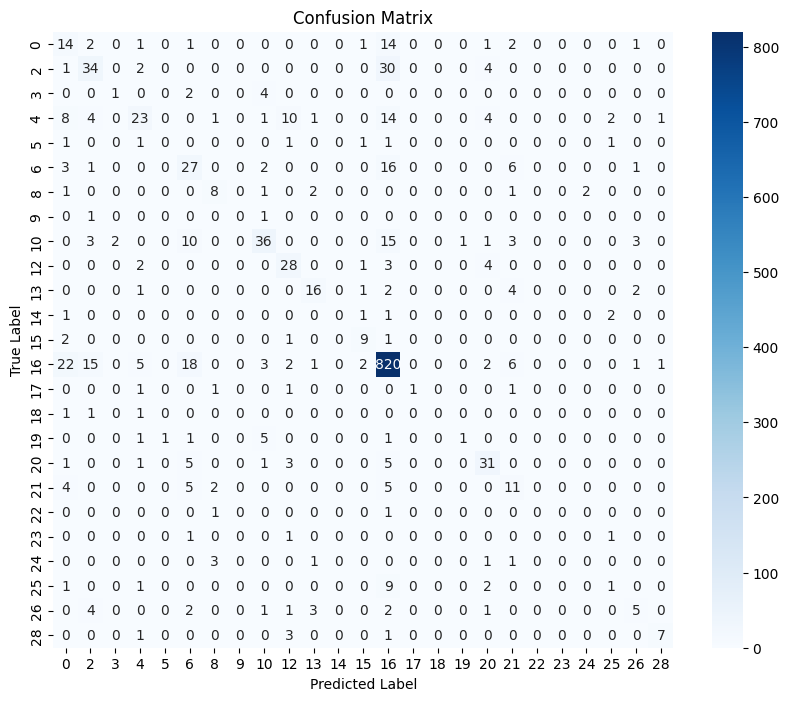

              precision    recall  f1-score   support

           0       0.23      0.38      0.29        37
           2       0.52      0.48      0.50        71
           3       0.33      0.14      0.20         7
           4       0.56      0.33      0.42        69
           5       0.00      0.00      0.00         6
           6       0.38      0.48      0.42        56
           8       0.50      0.53      0.52        15
           9       0.00      0.00      0.00         2
          10       0.65      0.49      0.56        74
          12       0.55      0.74      0.63        38
          13       0.67      0.62      0.64        26
          14       0.00      0.00      0.00         5
          15       0.56      0.69      0.62        13
          16       0.87      0.91      0.89       898
          17       1.00      0.20      0.33         5
          18       0.00      0.00      0.00         3
          19       0.50      0.10      0.17        10
          20       0.61    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import numpy as np
# Evaluate the model on the test set
test_results = model.evaluate(val_ds)
print(f"Test Accuracy: {test_results[1]*100:.2f}%")

# Predict categories on the test set for the confusion matrix
test_predictions = model.predict(val_ds)
test_predictions_indices = tf.argmax(test_predictions, axis=1).numpy()
true_labels = test_data['CATEGORY_encoded'].values

# Import confusion_matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Find unique classes in true labels
unique_classes = np.unique(true_labels)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, test_predictions_indices, labels=unique_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_classes, yticklabels=unique_classes) # Use unique_classes for labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report, using unique classes as target names
print(classification_report(true_labels, test_predictions_indices,
                            target_names=unique_classes.astype(str))) # Convert to strings for display

## Apply label to other data
Now that we have a model, it's time to predict labels for another dataset. We are predicting labels for ESCO skills
### Load ESCO Data
We begin by reading in the ESCO data and vectorizing the strings. We also remove the stopwords to decrease the runtime by removing non-predictive words.

In [ ]:
# Load and preprocess the ESCO dataset
url2 = 'https://github.com/Micah-Sanders/DATS6202/raw/main/ESCO%20skills%20Taxonomy.csv'
esco_data = pd.read_csv(url2)
esco_data = esco_data[['description']].dropna()
esco_data['description'] = esco_data['description'].astype(str).apply(remove_stopwords)

# Prepare ESCO data for prediction
esco_ds = tf.data.Dataset.from_tensor_slices(esco_data['description']).batch(64)



### Predict New ESCO Labels
We then use the trained model to predict the labels for the ESCO data. As we are trained on two layers, we need to predict two sets of labels.

In [ ]:
# Predict categories and subcategories using the trained model
predictions = model.predict(esco_ds)
predicted_categories_indices = tf.argmax(predictions, axis=1).numpy()

218/218 [==============================] - 39s 159ms/step


## Save Results
Finally, we need to format and save results to make sure we retain the new generated labels for the ESCO data.

In [ ]:
# Convert category indices to category names
predicted_categories = category_encoder.inverse_transform(predicted_categories_indices)

# Import
import random
from google.colab import drive

#Mount drive to save files
drive.mount('/content/drive')
# Store the results back in DataFrame for further analysis or export
esco_data['Predicted_Category'] = predicted_categories
esco_data.to_csv('/content/drive/My Drive/ESCO_with_Predicted_Categories.csv', index=False)

# Adjust sampling size based on the dataframe size
sample_size = min(50, len(esco_data))  # Sample at most 50, or the entire dataframe if smaller
sampled_data = random.sample(list(esco_data.index), sample_size) # Sample indices instead of the whole dataframe
sampled_data = esco_data.iloc[sampled_data] # Select the rows based on sampled indices
sampled_data.to_csv('/content/drive/My Drive/ESCO_with_Predicted_Categories_Sample_50.csv', index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Results
We were able to produce a trained model using Lightcast data and predict the labels on ESCO data. These labels need to verified so that they make some sense in the outside context. To do this, we used a typical hand coding technique to code a sample of 50 randomly selected skills from ESCO. We then compared these codes to the predicted label.

The results of this comparison were disappointing. The model predicted only 20% of the categories to be consistent with the hand coding. This is well below the model accuracy in the test/train data.

## Conclusion
The model not being particularly good at predicting categories shouldn't be too surprising. Given that 1/3 of the skills in Lightcast weren't labeled, we should have anticipated lower than expected accuracy. However, there is a deeper issue we discovered as we worked with the taxonomies. This is that Lightcast classifies their skills by occupation while ESCO uses a custom hierarchy that isn't directly workforce focused. This means that the skills descriptions are vastly different between the two data sets.

On a more model specific level, we see a propensity for the model to predict skills categories in which it has had little training. Conversely, skills which have more extensive training become less frequent. This may indicate that better trained categories are more accurate (we didn't test this hypothesis) or that the error range for undertrained categories encompasses much of the data. As we asked the model to predict categories for all the skills in ESCO, not just the high confidence ones, this is probably to be expected.

## Discussion
Overall, we feel that the RNN model we used was the correct model for this work, but the data wasn’t up to meeting the requirements to build a good RNN. In future, we will probably look for bigger and better labeled data before building this model again. It might also be wise to use fully unstructured data to build unsupervised learning models to build clusters from the data rather than imposing any taxonomy structure. This is specifically important when the skills definitions come from such different perspectives.

